In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install transformers

     |████████████████████████████████| 890kB 4.7MB/s 
     |████████████████████████████████| 890kB 23.4MB/s 
     |████████████████████████████████| 1.1MB 30.2MB/s 
     |████████████████████████████████| 3.0MB 24.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=536c84136b58de9b9304e2ea1e62b28a2ec97b1b20fcdd00aaa54316579ceb63
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from datetime import datetime
import sys
import seaborn as sns
sns.set(style="darkgrid")

#local
BASE_PATH = "/content/drive/My Drive/collab/"
# BASE_PATH = "/Users/samir/Dev/projects/MIMIC/"
sys.path.append(BASE_PATH+"TADAT/")

from tadat.pipeline import plots
from tadat.core import data, vectorizer, features, helpers, embeddings

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
raw_data_path = "/Users/samir/Dev/resources/datasets/MIMIC/full/"
out_data_path = BASE_PATH+"MIMIC/DATA/input/"
out_data_path

'/content/drive/My Drive/collab/MIMIC/DATA/input/'

## Analytics

In [5]:
def vectorize_data(train_split, test_split, test_split_M, test_split_F):
    #vectorize instances
    train_X = data.getX(train_split)
    test_X_M = data.getX(test_split_M)
    test_X_F = data.getX(test_split_F)
    test_X = data.getX(test_split)
    
    train_X, word_vocab = vectorizer.docs2idx(train_X)
    test_X_M,_ = vectorizer.docs2idx(test_X_M, word_vocab)
    test_X_F,_ = vectorizer.docs2idx(test_X_F, word_vocab)
    test_X,_ = vectorizer.docs2idx(test_X, word_vocab)
    
    #vectorize labels
    train_Y = data.getY(train_split)
    test_Y_M = data.getY(test_split_M) 
    test_Y_F = data.getY(test_split_F)   
    test_Y = data.getY(test_split)   
    
    label_vocab = vectorizer.get_labels_vocab(train_Y+test_Y)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    test_Y,_ = vectorizer.label2idx(test_Y, label_vocab)
    test_Y_M,_ = vectorizer.label2idx(test_Y_M, label_vocab)
    test_Y_F,_ = vectorizer.label2idx(test_Y_F, label_vocab)
    
    return train_X, train_Y, test_X, test_Y, test_X_M, test_Y_M, test_X_F, test_Y_F, word_vocab, label_vocab

def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-bin":
        X = features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-freq":
        X = features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-bin":
        X = features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-sum": 
        X = features.BOE(data, word_vectors,"sum")
    else:
        raise NotImplementedError
    return X
    
def get_BERT_embedding(X):
    X_cls, X_pool =  embeddings.transformer_encode_batches(X, batchsize=200, device="cuda")
    return X_cls, X_pool
    

def evaluate_classifier(model, X_test, Y_test,
                   labels, model_name, random_seed, res_path=None):
    Y_hat = model.predict(X_test)
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    acc = accuracy_score(Y_test, Y_hat)
    precision, recall, fscore, support = score(Y_test, Y_hat)

    res = {"model":model_name, \
            "seed":random_seed, \
            "acc":round(acc,3), \
            "microF1":round(microF1,3), \
            "macroF1":round(macroF1,3)
            }

    for l, i in labels.items():
        try:
            fs = round(fscore[i],3)
        except IndexError:
            fs = 0
        res["{}-f1".format(l)] = fs
    if res_path is not None:
        cols = ["dataset", "model", "acc", "avgF1"]        
        helpers.save_results(res, res_path, sep="\t")
    return res


def get_deltas(results_M, results_F):
    #resuts
    df_M = pd.DataFrame(results_M)
    df_F = pd.DataFrame(results_F)
    #compute deltas
    df_delta = df_M.sub(df_F.iloc[:,2:])
    df_delta["model"] = df_M["model"]
    df_delta["seed"] = df_M["seed"]   
    return df_delta

def run(df, x_label, y_label, feature_type, target_label, target_value, split=0.8):
    #split into training and test sets
    train_split, test_split = data.shuffle_split_idx(df[y_label], split)
    df_train = df.iloc[train_split,:]
    df_test = df.iloc[test_split,:]
    df_test_M = df_test[df_test[target_label] == target_value]
    df_test_F = df_test[df_test[target_label] != target_value]
    
    print("M: {} | F: {}".format(len(df_test_M),len(df_test_F)))
    #transform the data into the right format
    train = data.read_dataframe(df_train, x_label, y_label)
    test_M = data.read_dataframe(df_test_M, x_label, y_label)
    test_F = data.read_dataframe(df_test_F, x_label, y_label)
    test = data.read_dataframe(df_test, x_label, y_label)
    #get vectorized train/test data 
    train_X, train_Y, test_X, test_Y, test_X_M, test_Y_M, test_X_F, test_Y_F, word_vocab, label_vocab = vectorize_data(train, test, test_M, test_F)

    if "BOW" in feature_type:
        #extract features
        train_feats = get_features(train_X, len(word_vocab), feature_type)
        test_feats_M = get_features(test_X_M, len(word_vocab), feature_type)
        test_feats_F = get_features(test_X_F, len(word_vocab), feature_type)        
        test_feats = get_features(test_X, len(word_vocab), feature_type)        
    elif "BERT_CLS" == feature_type:
        train_feats, _ = get_BERT_embedding(train)
        test_feats_M, _ = get_BERT_embedding(test_M)
        test_feats_F, _ = get_BERT_embedding(test_F)
        test_feats, _ = get_BERT_embedding(test)
    elif "BERT_POOL" == feature_type:
        _, train_feats = get_BERT_embedding(train)
        _, test_feats_M = get_BERT_embedding(test_M)
        _, test_feats_F = get_BERT_embedding(test_F)
        _, test_feats = get_BERT_embedding(test)
    else:
        raise NotImplementedError    
#     set_trace()
    #train/test classifier for each random seed
    random_seeds = list(range(20))
    results = []
    results_m = []
    results_f = []
#     set_trace()
    for r in random_seeds:
        print("[running seed: {}]".format(r))
        model = SGDClassifier(random_state=r)
        model.fit(train_feats, train_Y)
        res = evaluate_classifier(model, test_feats, test_Y, label_vocab, feature_type, r)
        results.append(res)
        res_m = evaluate_classifier(model, test_feats_M, test_Y_M, label_vocab, feature_type, r)
        results_m.append(res_m)
        res_f = evaluate_classifier(model, test_feats_F, test_Y_F, label_vocab, feature_type, r)
        results_f.append(res_f)
    return results, results_m, results_f



# Analyses

In [6]:
def outcome_anaylsis(df, x_label, y_label, feature_type):
    
    results_W, results_M_W, results_F_W = run(df, x_label, y_label, feature_type, "ETHNICITY_BINARY", "WHITE", split=0.8)
    results_N, results_M_N, results_F_N = run(df, x_label, y_label, feature_type, "ETHNICITY_BINARY", "NON-WHITE", split=0.8)
    df_delta_W = get_deltas(results_M_W,results_F_W)
    df_delta_N = get_deltas(results_M_N,results_F_N)    
    df_delta_W["target"] = ["White v Others"]*len(df_delta_W)
    df_delta_N["target"] = ["Non-White v Others"]*len(df_delta_N)

    df_results = pd.DataFrame(results_W)
        
    return df_results, df_delta_W, df_delta_N 
    
    
def plot_catplot(df_delta_W,df_delta_N, title, LIM):
    df_delta = pd.concat([df_delta_W,df_delta_N])    
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model","target"], value_vars=["microF1","0-f1","1-f1"], 
                                        var_name="metric", value_name="delta")

    g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long, 
                    col="target",sharey=True,legend_out=True)
    ax1, ax2 = g.axes[0]
    ax1.axhline(0, ls='--',c="r")
    ax2.axhline(0, ls='--',c="r")
    ax1.set_ylim([-LIM,LIM])
    ax2.set_ylim([-LIM,LIM])
    plt.suptitle(title, y=1.01)
    plt.tight_layout()
    plt.show()  
        
def plot_performance(df, title):
    #plots
    fig, ax = plt.subplots(1,1, sharey=True, figsize=(18,5))
#   plots.plot_df(df=df,ax=ax,x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
    plots.plot_df(df=df,ax=ax,x="seed",ys=["microF1","1-f1","0-f1"], annotation_size=10)
    ax.legend(loc='best')
    fig.suptitle(title ,y=1.01)
    plt.tight_layout()





## mortality 

In [7]:
df_mortality = pd.read_csv(out_data_path+"mini_mortality_balanced.csv",sep="\t", header=None, names=["EXPIRE","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"])
df_mortality 

,EXPIRE,TEXT,GENDER,ETHNICITY_LABEL,ETHNICITY_BINARY
0,1,admission date: [**2158-1-5**] d...,F,OTHER,OTHER
1,1,admission date: [**2169-9-11**] ...,M,OTHER,OTHER
2,1,admission date: [**2131-6-17**] ...,M,OTHER,OTHER
3,1,admission date: [**2140-7-27**] dischar...,F,WHITE,WHITE
4,1,admission date: [**2140-7-15**] ...,F,OTHER,OTHER
...,...,...,...,...,...
3927,0,admission date: [**2184-7-5**] discharge ...,F,WHITE,WHITE
3928,0,admission date: [**2103-7-17**] ...,M,ASIAN,NON-WHITE
3929,0,admission date: [**2191-2-23**] ...,M,ASIAN,NON-WHITE
3930,0,admission date: [**2157-12-1**] ...,M,WHITE,WHITE


In [8]:
df_bb, df_bb_delta_W, df_bb_delta_N = outcome_anaylsis(df_mortality,"TEXT","EXPIRE", "BOW-bin")
df_bf, df_bf_delta_W, df_bf_delta_N = outcome_anaylsis(df_mortality,"TEXT","EXPIRE", "BOW-freq")
df_bertcls, df_bertcls_delta_W, df_bertcls_delta_N = outcome_anaylsis(df_mortality,"TEXT","EXPIRE", "BERT_CLS")
df_bertpool, df_bertpool_delta_W, df_bertpool_delta_N = outcome_anaylsis(df_mortality,"TEXT","EXPIRE", "BERT_POOL")


M: 545 | F: 243
(sparse BOW)
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]
[running seed: 3]
[running seed: 4]
[running seed: 5]
[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]
[running seed: 10]
[running seed: 11]
[running seed: 12]
[running seed: 13]
[running seed: 14]
[running seed: 15]
[running seed: 16]
[running seed: 17]
[running seed: 18]
[running seed: 19]
M: 93 | F: 695
(sparse BOW)
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]
[running seed: 3]
[running seed: 4]
[running seed: 5]
[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]
[running seed: 10]
[running seed: 11]
[running seed: 12]
[running seed: 13]
[running seed: 14]
[running seed: 15]
[running seed: 16]
[running seed: 17]
[running seed: 18]
[running seed: 19]
M: 545 | F: 243
(sparse BOW)
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]
[ru



batch:1/16 (size: 200)[max len: 510]

batch:2/16 (size: 200)[max len: 510]

batch:3/16 (size: 200)[max len: 510]

batch:4/16 (size: 200)[max len: 510]

batch:5/16 (size: 200)[max len: 510]

batch:6/16 (size: 200)[max len: 510]

batch:7/16 (size: 200)[max len: 510]

batch:8/16 (size: 200)[max len: 510]

batch:9/16 (size: 200)[max len: 510]

batch:10/16 (size: 200)[max len: 510]

batch:11/16 (size: 200)[max len: 510]

batch:12/16 (size: 200)[max len: 510]

batch:13/16 (size: 200)[max len: 510]

batch:14/16 (size: 200)[max len: 510]

batch:15/16 (size: 200)[max len: 510]

batch:16/16 (size: 144)[max len: 510]

batch:1/3 (size: 200)[max len: 510]

batch:2/3 (size: 200)[max len: 510]

batch:3/3 (size: 145)[max len: 510]

batch:1/2 (size: 200)[max len: 510]

batch:2/2 (size: 43)[max len: 510]

batch:1/4 (size: 200)[max len: 510]

batch:2/4 (size: 200)[max len: 510]

batch:3/4 (size: 200)[max len: 510]

batch:4/4 (size: 188)[max len: 510]
[running seed: 0]
[running seed: 1]
[running seed: 2

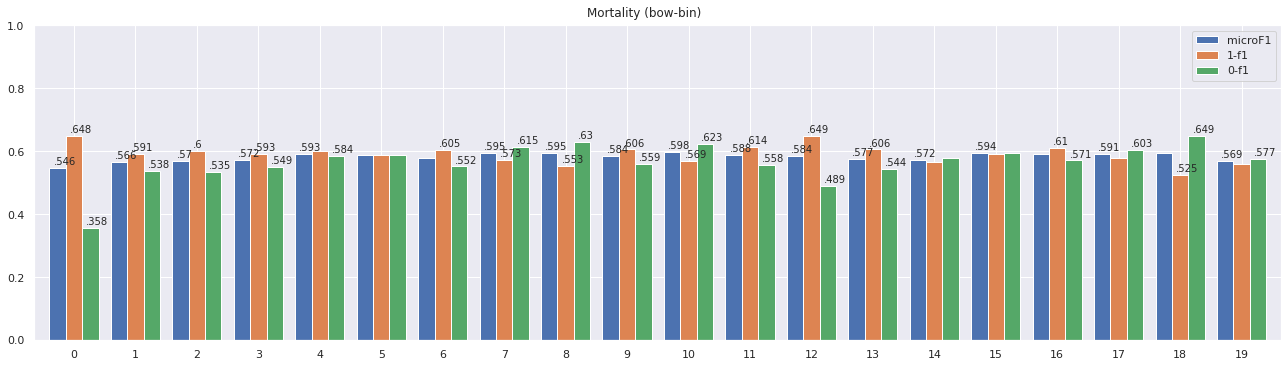

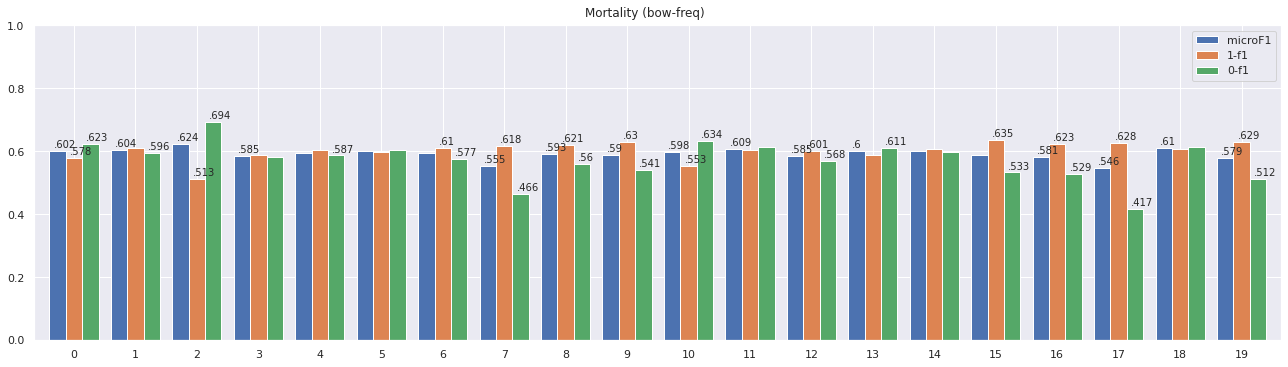

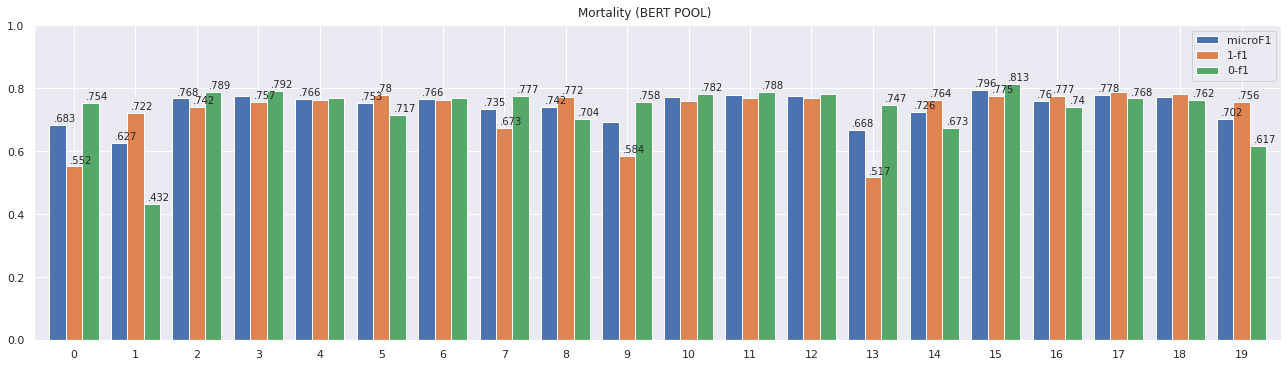

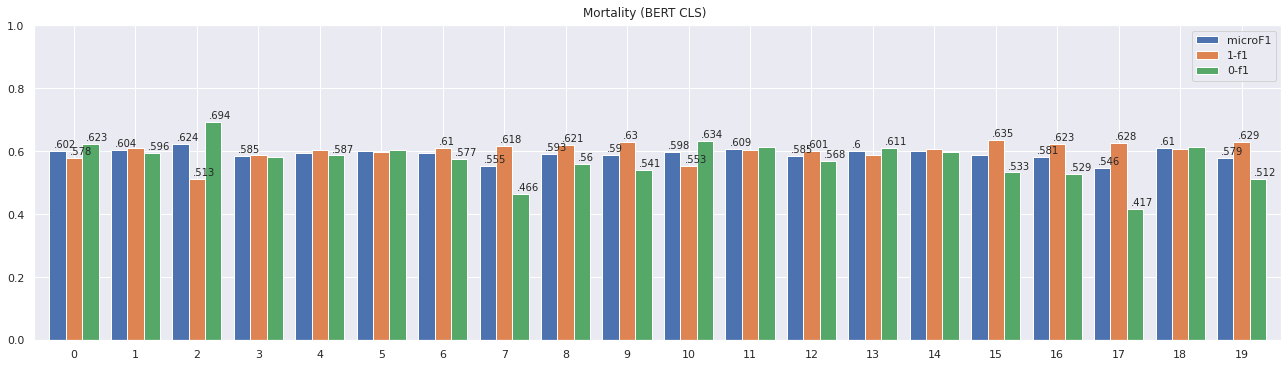

In [9]:
plot_performance(df_bb, "Mortality (bow-bin)")
plot_performance(df_bf, "Mortality (bow-freq)")
plot_performance(df_bertpool, "Mortality (BERT POOL)")
plot_performance(df_bf, "Mortality (BERT CLS)")


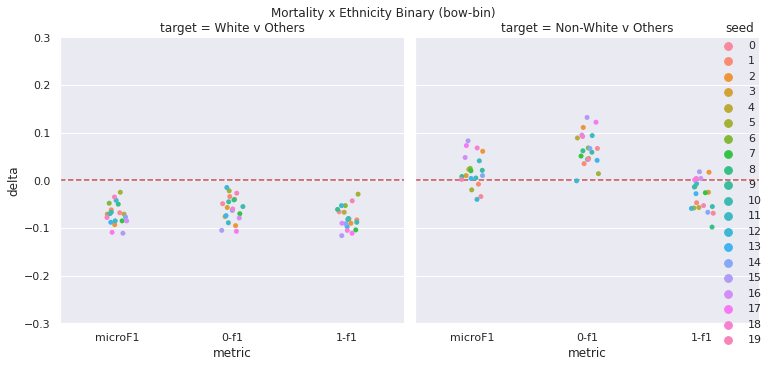

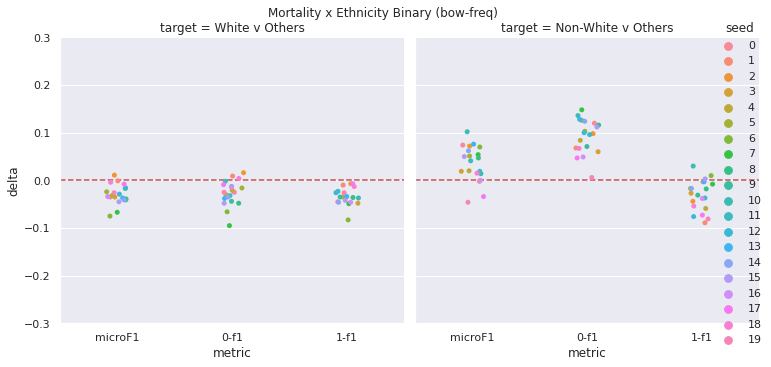

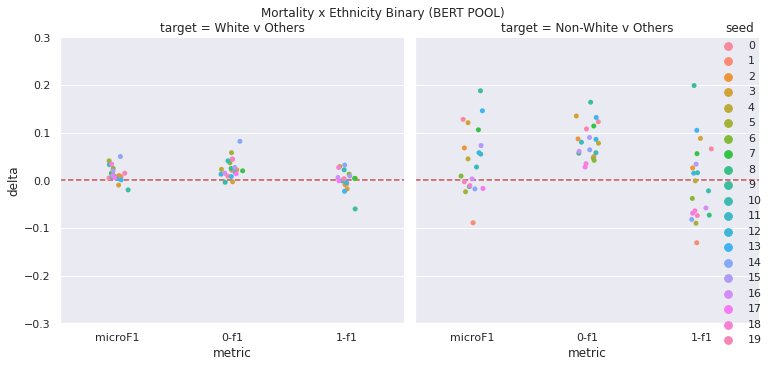

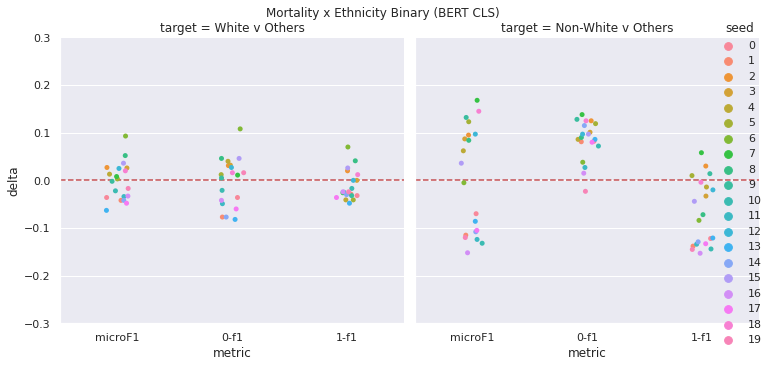

In [10]:
LIM=0.3
plot_catplot(df_bb_delta_W, df_bb_delta_N, "Mortality x Ethnicity Binary (bow-bin)", LIM)
plot_catplot(df_bf_delta_W, df_bf_delta_N, "Mortality x Ethnicity Binary (bow-freq)", LIM)
plot_catplot(df_bertpool_delta_W, df_bertpool_delta_N, "Mortality x Ethnicity Binary (BERT POOL)", LIM)
plot_catplot(df_bertcls_delta_W, df_bertcls_delta_N, "Mortality x Ethnicity Binary (BERT CLS)", LIM)

## readmissions


In [11]:
df_readmission = pd.read_csv(out_data_path+"mini_readmissions_balanced.csv",sep="\t", header=None, names=["READMISSION","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"])
df_readmission

,READMISSION,TEXT,GENDER,ETHNICITY_LABEL,ETHNICITY_BINARY
0,1,admission date: [**2149-6-2**] discharg...,F,NaN,NaN
1,1,admission date: [**2133-9-3**] d...,M,NaN,NaN
2,1,admission date: [**2113-5-10**] discharge...,M,NaN,NaN
3,1,admission date: [**2159-8-1**] d...,M,NaN,NaN
4,1,admission date: [**2140-7-27**] dischar...,F,NaN,NaN
...,...,...,...,...,...
6627,0,admission date: [**2142-7-16**] ...,M,WHITE,WHITE
6628,0,admission date: [**2145-7-25**] ...,F,OTHER,OTHER
6629,0,admission date: [**2143-11-16**] ...,F,WHITE,WHITE
6630,0,admission date: [**2176-7-15**] dischar...,M,OTHER,OTHER


In [12]:
df_rea_bb, df_rea_bb_delta_W, df_rea_bb_delta_N = outcome_anaylsis(df_readmission,"TEXT","READMISSION", "BOW-bin")
df_rea_bf, df_rea_bf_delta_W, df_rea_bf_delta_N = outcome_anaylsis(df_readmission,"TEXT","READMISSION", "BOW-freq")
df_rea_bertpool, df_rea_bertpool_delta_W, df_rea_bertpool_delta_N = outcome_anaylsis(df_readmission,"TEXT","READMISSION", "BERT_POOL")
df_rea_bertcls, df_rea_bertcls_delta_W, df_rea_bertcls_delta_N = outcome_anaylsis(df_readmission,"TEXT","READMISSION", "BERT_CLS")




M: 451 | F: 877
(sparse BOW)
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 1]
[running seed: 2]
[running seed: 3]
[running seed: 4]
[running seed: 5]
[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]
[running seed: 10]
[running seed: 11]
[running seed: 12]
[running seed: 13]
[running seed: 14]
[running seed: 15]
[running seed: 16]
[running seed: 17]
[running seed: 18]
[running seed: 19]
M: 119 | F: 1209
(sparse BOW)
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]
[running seed: 3]
[running seed: 4]
[running seed: 5]
[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]
[running seed: 10]
[running seed: 11]
[running seed: 12]
[running seed: 13]
[running seed: 14]
[running seed: 15]
[running seed: 16]
[running seed: 17]
[running seed: 18]
[running seed: 19]
M: 451 | F: 877
(sparse BOW)
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]
[running seed: 3]
[running seed: 4]
[running seed: 5]
[running seed: 6]
[running seed: 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 1]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 2]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 3]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 4]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 5]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 6]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 7]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 8]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 9]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 10]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 11]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 12]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 13]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 14]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 15]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 16]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 17]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 18]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 19]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


M: 119 | F: 1209

batch:1/27 (size: 200)[max len: 510]

batch:2/27 (size: 200)[max len: 510]

batch:3/27 (size: 200)[max len: 510]

batch:4/27 (size: 200)[max len: 510]

batch:5/27 (size: 200)[max len: 510]

batch:6/27 (size: 200)[max len: 510]

batch:7/27 (size: 200)[max len: 510]

batch:8/27 (size: 200)[max len: 510]

batch:9/27 (size: 200)[max len: 510]

batch:10/27 (size: 200)[max len: 510]

batch:11/27 (size: 200)[max len: 510]

batch:12/27 (size: 200)[max len: 510]

batch:13/27 (size: 200)[max len: 510]

batch:14/27 (size: 200)[max len: 510]

batch:15/27 (size: 200)[max len: 510]

batch:16/27 (size: 200)[max len: 510]

batch:17/27 (size: 200)[max len: 510]

batch:18/27 (size: 200)[max len: 510]

batch:19/27 (size: 200)[max len: 510]

batch:20/27 (size: 200)[max len: 510]

batch:21/27 (size: 200)[max len: 510]

batch:22/27 (size: 200)[max len: 510]

batch:23/27 (size: 200)[max len: 510]

batch:24/27 (size: 200)[max len: 510]

batch:25/27 (size: 200)[max len: 510]

batch:26/27 (siz

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 1]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 2]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 3]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 4]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 5]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 6]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 7]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 8]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 9]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 10]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 11]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 12]
[running seed: 13]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 14]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 15]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 16]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 17]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 18]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 19]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


M: 451 | F: 877

batch:1/27 (size: 200)[max len: 510]

batch:2/27 (size: 200)[max len: 510]

batch:3/27 (size: 200)[max len: 510]

batch:4/27 (size: 200)[max len: 510]

batch:5/27 (size: 200)[max len: 510]

batch:6/27 (size: 200)[max len: 510]

batch:7/27 (size: 200)[max len: 510]

batch:8/27 (size: 200)[max len: 510]

batch:9/27 (size: 200)[max len: 510]

batch:10/27 (size: 200)[max len: 510]

batch:11/27 (size: 200)[max len: 510]

batch:12/27 (size: 200)[max len: 510]

batch:13/27 (size: 200)[max len: 510]

batch:14/27 (size: 200)[max len: 510]

batch:15/27 (size: 200)[max len: 510]

batch:16/27 (size: 200)[max len: 510]

batch:17/27 (size: 200)[max len: 510]

batch:18/27 (size: 200)[max len: 510]

batch:19/27 (size: 200)[max len: 510]

batch:20/27 (size: 200)[max len: 510]

batch:21/27 (size: 200)[max len: 510]

batch:22/27 (size: 200)[max len: 510]

batch:23/27 (size: 200)[max len: 510]

batch:24/27 (size: 200)[max len: 510]

batch:25/27 (size: 200)[max len: 510]

batch:26/27 (size

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 1]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 2]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 3]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 4]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 5]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 6]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 7]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 8]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 9]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 10]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 11]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 12]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 13]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 14]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 15]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 16]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 17]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 18]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 19]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


M: 119 | F: 1209

batch:1/27 (size: 200)[max len: 510]

batch:2/27 (size: 200)[max len: 510]

batch:3/27 (size: 200)[max len: 510]

batch:4/27 (size: 200)[max len: 510]

batch:5/27 (size: 200)[max len: 510]

batch:6/27 (size: 200)[max len: 510]

batch:7/27 (size: 200)[max len: 510]

batch:8/27 (size: 200)[max len: 510]

batch:9/27 (size: 200)[max len: 510]

batch:10/27 (size: 200)[max len: 510]

batch:11/27 (size: 200)[max len: 510]

batch:12/27 (size: 200)[max len: 510]

batch:13/27 (size: 200)[max len: 510]

batch:14/27 (size: 200)[max len: 510]

batch:15/27 (size: 200)[max len: 510]

batch:16/27 (size: 200)[max len: 510]

batch:17/27 (size: 200)[max len: 510]

batch:18/27 (size: 200)[max len: 510]

batch:19/27 (size: 200)[max len: 510]

batch:20/27 (size: 200)[max len: 510]

batch:21/27 (size: 200)[max len: 510]

batch:22/27 (size: 200)[max len: 510]

batch:23/27 (size: 200)[max len: 510]

batch:24/27 (size: 200)[max len: 510]

batch:25/27 (size: 200)[max len: 510]

batch:26/27 (siz

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 1]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 2]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 3]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 4]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 5]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 6]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 7]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 8]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 9]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 10]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 11]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 12]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 13]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 14]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 15]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 16]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 17]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 18]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[running seed: 19]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


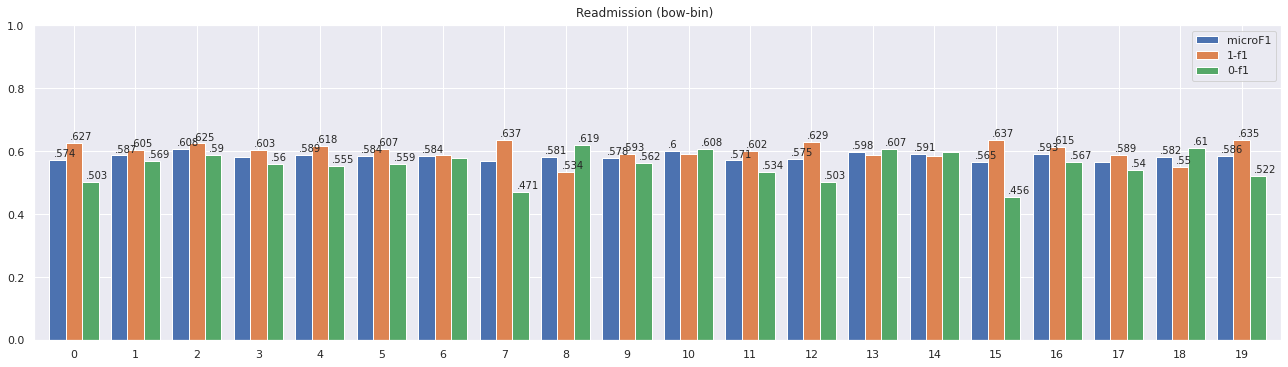

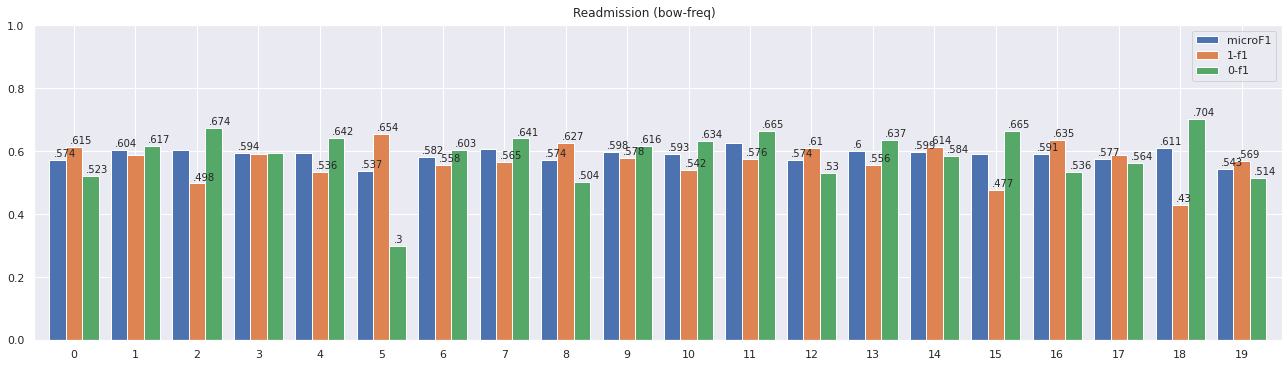

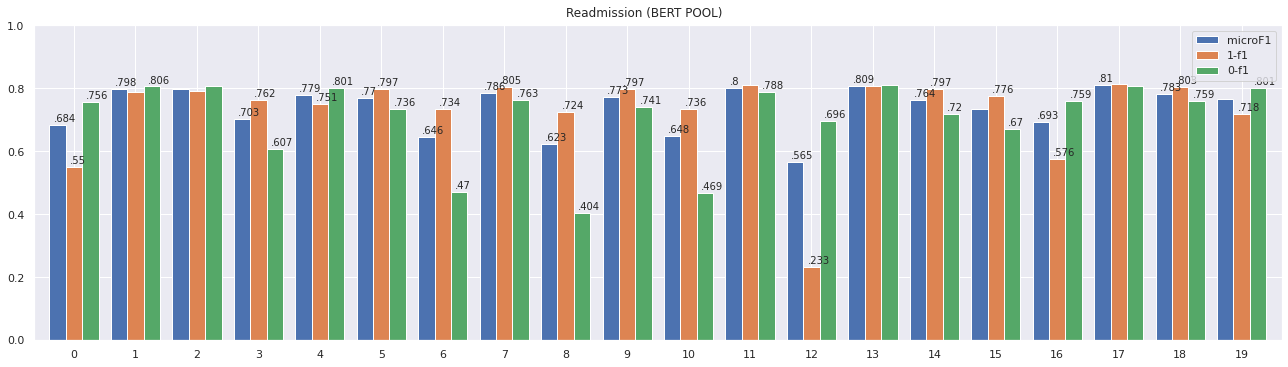

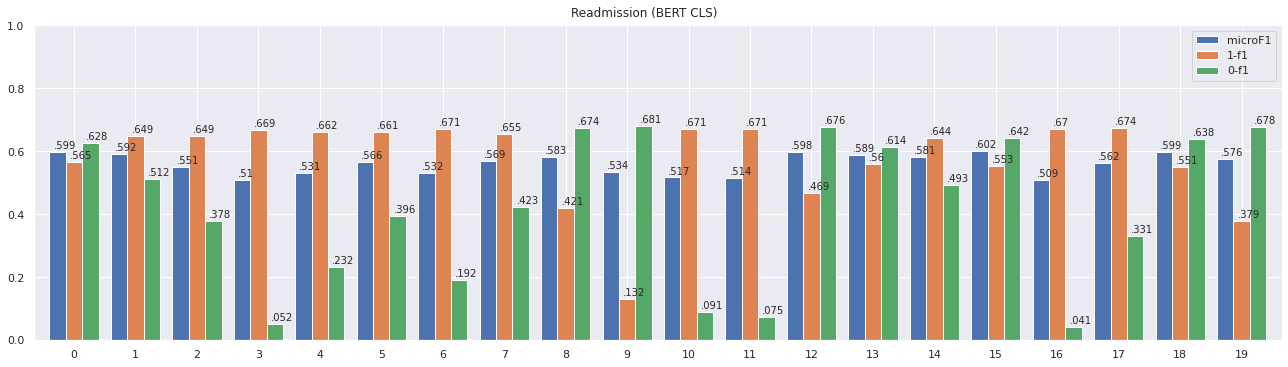

In [15]:
plot_performance(df_rea_bb, "Readmission (bow-bin)")
plot_performance(df_rea_bf, "Readmission (bow-freq)")
plot_performance(df_rea_bertpool, "Readmission (BERT POOL)")
plot_performance(df_rea_bertcls, "Readmission (BERT CLS)")

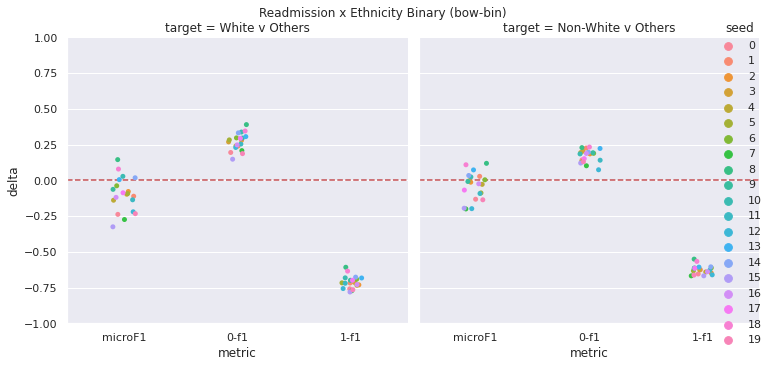

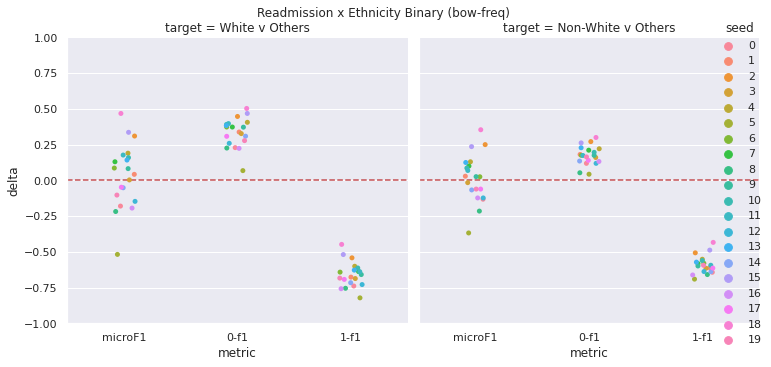

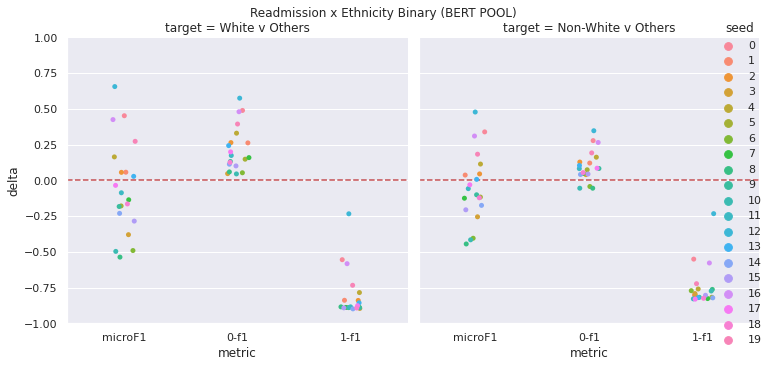

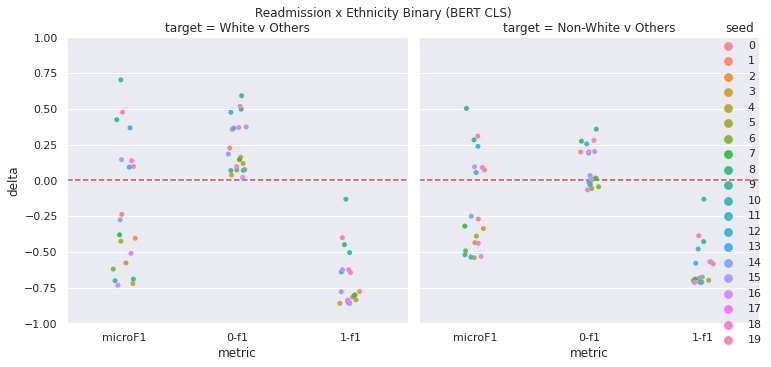

In [16]:
LIM = 1
plot_catplot(df_rea_bb_delta_W, df_rea_bb_delta_N, "Readmission x Ethnicity Binary (bow-bin)", LIM)
plot_catplot(df_rea_bf_delta_W, df_rea_bf_delta_N, "Readmission x Ethnicity Binary (bow-freq)", LIM)
plot_catplot(df_rea_bertpool_delta_W, df_rea_bertpool_delta_N, "Readmission x Ethnicity Binary (BERT POOL)", LIM)
plot_catplot(df_rea_bertcls_delta_W, df_rea_bertcls_delta_N, "Readmission x Ethnicity Binary (BERT CLS)", LIM)
